In [1]:
import numpy as np
import pandas as pd
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
from matplotlib import cm
import os
import glob
import re

In [2]:
from pathlib import Path
import os.path
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from sklearn.metrics import r2_score

## Preparing the dataset of images for CNN

In [3]:
imgFileLocation = pd.Series(name = 'image_paths', dtype = str)
x_coordinates = pd.Series(name = 'x', dtype = float)
y_coordinates = pd.Series(name = 'y', dtype = float)

In [4]:
####################----> creating a panda series containing the path names for all the images created.

imfolder = r'<INSERT PATH HERE TO FOLDER WITH IMAGES>'
folder = (os.path.join(imfolder,r'*.png'))
print(folder)


C:\Users\ratho\Desktop\CI\Project_B_Data\DATA\fin_imgset\*.png


In [5]:
i = 0

for name in glob.glob(folder):
    fpath = name
    
    split_name = re.split(r"\\", name)
    coords = re.split("_|\.", split_name[-1])
    x = int(coords[0])
    y = int(coords[1])
    pos = [(x-175)/(325-175), (y-175)/(325-175)]
    #print(pos[0])
    
    
    x_coordinates.loc[i] = pos[0]
    y_coordinates.loc[i] = pos[1]
    imgFileLocation.loc[i] = fpath
    i+=1

In [6]:
images = pd.concat([imgFileLocation, x_coordinates, y_coordinates], axis = 1).sample(frac = 1.0, random_state = 1).reset_index(drop='True')
train_df, test_df = train_test_split(images, train_size = 0.8, shuffle = True, random_state = 1)

## Generating training, validation and test batches of our dataset using flow_from_dataframe

In [7]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    validation_split = 0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255
)

In [8]:
size  = (170, 134)
inputshape = (170, 134, 1)
train_images = train_generator.flow_from_dataframe(
    dataframe = train_df,
    x_col = 'image_paths',
    y_col = ['x','y'],
    target_size = size,
    color_mode = 'grayscale',
    class_mode = 'raw',
    batch_size = 32,
    shuffle = True,
    seed = 42,
    subset = 'training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe = train_df,
    x_col = 'image_paths',
    y_col = ['x','y'],
    target_size = size,
    color_mode = 'grayscale',
    class_mode = 'raw',
    batch_size = 32,
    shuffle = True,
    seed = 42,
    subset = 'validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe = test_df,
    x_col = 'image_paths',
    y_col = ['x','y'],
    target_size = size,
    color_mode = 'grayscale',
    class_mode = 'raw',
    batch_size = 32,
    shuffle = True,
)

Found 608 validated image filenames.
Found 151 validated image filenames.
Found 190 validated image filenames.


##  Tuning, filters, num_layers, dropout rate using Keras Tuner

In [34]:
def build_model4(hp):
    model = keras.models.Sequential()
    fls = hp.Int('filters', min_value=16, max_value=64, step=16)
    dr = hp.Choice('dr_rate', values=[0.2, 0.3, 0.4, 0.5])
    model.add(keras.layers.Conv2D(filters=fls, kernel_size=(3,3), activation = 'relu', padding='same', input_shape=inputshape)),
    model.add(keras.layers.MaxPool2D(pool_size=(2,2),padding='same')),
    model.add(keras.layers.Dropout(dr)),
    
    for i in range(hp.Int('layers',1,4)):
        model.add(keras.layers.Conv2D(filters= fls*(i+1), kernel_size=(3,3), activation = 'relu', padding='same')),
        model.add(keras.layers.MaxPool2D(pool_size=(2,2),padding='same')),
        model.add(keras.layers.Dropout(dr)),
        
    model.add(keras.layers.Flatten()),
    model.add(keras.layers.Dense(2, activation='linear')),
    model.compile(optimizer= 'adam', loss='mean_squared_error', metrics=['mse'])
              
    return model

In [35]:
tuner = kt.RandomSearch(
        build_model4,
        objective='val_loss',
        max_trials=10,
        executions_per_trial=1,
        directory='moreTuning'
)

In [62]:
tuner.search_space_summary()

Search space summary
Default search space size: 3
filters (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 64, 'step': 16, 'sampling': None}
dr_rate (Choice)
{'default': 0.2, 'conditions': [], 'values': [0.2, 0.3, 0.4, 0.5], 'ordered': True}
layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 4, 'step': 1, 'sampling': None}


In [37]:
es_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [38]:
tuner.search(train_images, epochs=50, validation_data=val_images, callbacks=[es_cb])

Trial 10 Complete [00h 07m 38s]
val_loss: 0.06517301499843597

Best val_loss So Far: 0.03083711676299572
Total elapsed time: 00h 39m 01s
INFO:tensorflow:Oracle triggered exit


In [63]:
tuner.results_summary()

Results summary
Results in moreTuning\untitled_project
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
filters: 48
dr_rate: 0.2
layers: 2
Score: 0.03083711676299572
Trial summary
Hyperparameters:
filters: 48
dr_rate: 0.2
layers: 1
Score: 0.039259087294340134
Trial summary
Hyperparameters:
filters: 32
dr_rate: 0.2
layers: 2
Score: 0.05867550149559975
Trial summary
Hyperparameters:
filters: 16
dr_rate: 0.4
layers: 4
Score: 0.06517301499843597
Trial summary
Hyperparameters:
filters: 48
dr_rate: 0.3
layers: 1
Score: 0.09688789397478104
Trial summary
Hyperparameters:
filters: 48
dr_rate: 0.5
layers: 3
Score: 0.14801546931266785
Trial summary
Hyperparameters:
filters: 48
dr_rate: 0.4
layers: 1
Score: 0.1488083451986313
Trial summary
Hyperparameters:
filters: 16
dr_rate: 0.3
layers: 3
Score: 0.15270166099071503
Trial summary
Hyperparameters:
filters: 48
dr_rate: 0.4
layers: 4
Score: 0.17267940938472748
Trial summary
Hyperparameters:
filters: 3

### Model Fitting with Best Parameters

In [64]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
model=tuner.hypermodel.build(best_hps)

In [65]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 170, 134, 48)      480       
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 85, 67, 48)       0         
 g2D)                                                            
                                                                 
 dropout_11 (Dropout)        (None, 85, 67, 48)        0         
                                                                 
 conv2d_12 (Conv2D)          (None, 85, 67, 48)        20784     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 43, 34, 48)       0         
 g2D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 43, 34, 48)       

In [66]:
es_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tb_cb = tf.keras.callbacks.TensorBoard(log_dir="logs45/", histogram_freq=1)

In [67]:
history = model.fit(train_images, epochs=100, validation_data=val_images, callbacks = [es_cb, tb_cb])

Epoch 1/100
19/19 [==============================] - 24s 1s/step - loss: 0.3591 - mse: 0.3591 - val_loss: 0.1982 - val_mse: 0.1982
Epoch 2/100
19/19 [==============================] - 18s 958ms/step - loss: 0.1022 - mse: 0.1022 - val_loss: 0.1503 - val_mse: 0.1503
Epoch 3/100
19/19 [==============================] - 18s 954ms/step - loss: 0.0885 - mse: 0.0885 - val_loss: 0.1296 - val_mse: 0.1296
Epoch 4/100
19/19 [==============================] - 18s 964ms/step - loss: 0.0690 - mse: 0.0690 - val_loss: 0.0910 - val_mse: 0.0910
Epoch 5/100
19/19 [==============================] - 19s 991ms/step - loss: 0.0356 - mse: 0.0356 - val_loss: 0.0550 - val_mse: 0.0550
Epoch 6/100
19/19 [==============================] - 18s 969ms/step - loss: 0.0194 - mse: 0.0194 - val_loss: 0.0414 - val_mse: 0.0414
Epoch 7/100
19/19 [==============================] - 19s 994ms/step - loss: 0.0125 - mse: 0.0125 - val_loss: 0.0314 - val_mse: 0.0314
Epoch 8/100
19/19 [==============================] - 19s 990ms/st

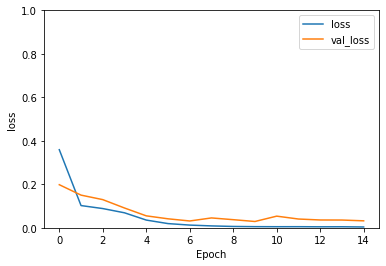

In [70]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.ylim([0.0, 1])
plt.legend(loc='upper right')

In [71]:
%load_ext tensorboard

%tensorboard --logdir logs45\fit

In [77]:
pred_coordi = np.squeeze(model.predict(val_images))
true_coordi = val_images.labels

r2 = r2_score(true_coordi, pred_coordi)
print("Test R^2 Score: {:.5f}".format(r2))

Test R^2 Score: -0.78736


### Finding Runtime

In [ ]:
import time


In [ ]:
start = time.time()
model.fit() # Training statement
print("Total time: ", time.time() - start, "seconds")